In [40]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [41]:
import pandas as pd
import polars as pl
import polars.selectors as cs
from catboost import Pool, CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tempfile
import os
import zipfile

pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000


In [42]:
def read_dataset_export(file_name, src_folder=".",
                        tmp_folder=None,
                        lazy=False,
                        verbose=False):
    json_file = None
    error_reason = ""
    tmp_folder = tmp_folder if tmp_folder else tempfile.gettempdir()

    if file_name.endswith(".json"):
        error_reason = "Error reading JSON file"
        if os.path.exists(file_name):
            json_file = file_name
        elif os.path.exists(os.path.join(src_folder, file_name)):
            json_file = os.path.join(src_folder, file_name)
        if json_file and verbose:
            print(error_reason, json_file)
        if json_file:
            if lazy:
                multi_line_json = pl.scan_ndjson(json_file)
            else:
                multi_line_json = pl.read_ndjson(json_file)

    else:
        zip_file = file_name
        if file_name.endswith(".zip"):
            error_reason = "Error reading ZIP file"
            if os.path.exists(file_name):
                zip_file = file_name
            elif os.path.exists(os.path.join(src_folder, file_name)):
                zip_file = os.path.join(src_folder, file_name)
            if verbose:
                print(error_reason, zip_file)

            if os.path.exists(zip_file):
                error_reason = "Error extracting data.json"
                if verbose:
                    print(error_reason, zip_file)

                json_file = os.path.join(tmp_folder, "data.json")
                if os.path.exists(json_file):
                    os.remove(json_file)

                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    all_zip_entries = zip_ref.namelist()
                    json_file_in_zip = [s for s in all_zip_entries if "data.json" in s]
                    if verbose:
                        print("data.json in zip file:", json_file_in_zip, zip_file)

                    for file in json_file_in_zip:
                        zip_ref.extract(file, tmp_folder)
                        json_file = os.path.join(tmp_folder, file)

                if not os.path.exists(json_file):
                    raise Exception(f"Dataset zipfile {zip_file} does not have \"data.json\"")
                if lazy:
                    multi_line_json = pl.scan_ndjson(json_file, infer_schema_length=10000)
                else:
                    multi_line_json = pl.read_ndjson(json_file, infer_schema_length=10000)
                    os.remove(json_file)

    if json_file is None:
        raise Exception(f"Dataset export not found {error_reason}")
    return multi_line_json

In [43]:
df = read_dataset_export( "Web_ClickThrough.zip", lazy=True, verbose=True)
df.describe()

Error reading ZIP file Web_ClickThrough.zip
Error extracting data.json Web_ClickThrough.zip
data.json in zip file: ['data.json'] Web_ClickThrough.zip


statistic,Customer_IsBankruptcy,Customer_OrganizationID,Customer_IsCustomerActive,Customer_PrimaryState,Param_JourneyStage,Decision_OutcomeTime,id,Customer_HasBrokenPromise,Decision_Outcome,IH_Web_Inbound_Impression_pyHistoricalOutcomeCount,Context_Direction,Customer_NumDepositAccount,Param_LastJourneyStage,pyModelPerformance,Customer_TotalLiabilities,Context_Channel,Customer_IsInActiveComplaint,pyModelPositives,Customer_BirthDate,Param_Journey,IH_Web_Inbound_Clicked_pxLastOutcomeTime_DaysSince,Context_Name,IH_Web_Inbound_Impression_pxLastGroupID,Customer_IsInPrecollections,Customer_OwnershipStatus,negativeSampling,Customer_IsFinanciallyVulnerable,Customer_NumLoanAccount,rulesetName,IH_Web_Inbound_Impression_pxLastOutcomeTime_DaysSince,dataCenter,Customer_PrimaryCountryCode,pyPropensity,Param_DaysinCurrentStage,IH_Retail_Inbound_Impression_pyHistoricalOutcomeCount,Customer_IsStudent,…,Decision_InteractionID,Customer_NumInvestmentAccount,Customer_PrimaryPostalCode,Customer_ResidentialStatus,Param_PriorStageInJourney,Customer_NetWealth,Decision_SubjectID,Decision_DecisionTime,Customer_IsActiveMilitaryService,Customer_TotalAssets,Customer_IsInDisasterArea,Customer_IsB2C,positiveSampling,Customer_PrimaryMobilePhone,Context_Issue,Context_Treatment,Customer_MKTCLVValue,IH_Retail_Inbound_Impression_pxLastGroupID,IH_Retail_Inbound_Impression_pxLastOutcomeTime_DaysSince,Customer_DebtToIncomeRatio,IH_Web_Inbound_Clicked_pyHistoricalOutcomeCount,Customer_IsCreditScoreStale,Customer_CLV,Customer_CreditScore,Customer_PrimaryCity,Customer_HasCriticalIllness,Decision_OutcomeWeight,Decision_Rank,Customer_RelationshipLengthDays,IH_Web_Inbound_Clicked_pxLastGroupID,Customer_IsInArrears,pyModelEvidence,rulesetVersion,Customer_IsIncarcerated,Customer_AnnualIncome,Customer_LinkedIn,Customer_OrganizationName
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""count""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""",22578.0,"""22578""","""125""","""22578""",…,"""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""125""","""125""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578""","""22578"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""22453""","""0""",…,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""22453""","""22453""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.588483,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""std""",n

In [44]:
columns = df.collect_schema().names()
columns.sort()
columns

['Context_Channel',
 'Context_Direction',
 'Context_Group',
 'Context_Issue',
 'Context_Name',
 'Context_Treatment',
 'Customer_AnnualIncome',
 'Customer_BirthDate',
 'Customer_CLV',
 'Customer_CreditScore',
 'Customer_DebtToIncomeRatio',
 'Customer_HasBrokenPromise',
 'Customer_HasCriticalIllness',
 'Customer_IsActiveMilitaryService',
 'Customer_IsB2C',
 'Customer_IsBankruptcy',
 'Customer_IsCreditScoreStale',
 'Customer_IsCustomerActive',
 'Customer_IsFinanciallyVulnerable',
 'Customer_IsInActiveComplaint',
 'Customer_IsInArrears',
 'Customer_IsInCollections',
 'Customer_IsInDisasterArea',
 'Customer_IsInPrecollections',
 'Customer_IsIncarcerated',
 'Customer_IsProspect',
 'Customer_IsStudent',
 'Customer_LinkedIn',
 'Customer_MKTCLVValue',
 'Customer_NetWealth',
 'Customer_NumCreditCardAccount',
 'Customer_NumDepositAccount',
 'Customer_NumInvestmentAccount',
 'Customer_NumLoanAccount',
 'Customer_OrganizationID',
 'Customer_OrganizationName',
 'Customer_OwnershipStatus',
 'Customer

In [45]:
df = df.unique(subset=['Decision_InteractionID', 'Context_Treatment'], keep='last')

In [46]:
df = df.with_columns(
    pl.when(pl.col(pl.String).str.len_chars() == 0)
    .then(None)
    .otherwise(pl.col(pl.String))
    .name.keep()
    ).with_columns(
        cs.ends_with("_DaysSince", 
                     "_pyHistoricalOutcomeCount",
                     "DaysinCurrentStage")
                     .cast(pl.Float64).fill_null(0),
        pl.col(
            [
                "Customer_AnnualIncome",
                "Customer_CreditScore",
                "Customer_DebtToIncomeRatio",
                "Customer_NetWealth",
                "Customer_RelationshipLengthDays",
                "Customer_TotalAssets",
                "Customer_TotalLiabilities",
                "Customer_BirthDate"
            ]
            )
        .cast(pl.Float64)
        .fill_null(0),
        cs.starts_with("Customer_Num").cast(pl.Float64).fill_null(0),
        cs.starts_with("Context_").cast(pl.String),
        cs.starts_with("Customer_Is").replace_strict({"false":False, "true":True, "null":False, "False":False, "True":True}),
        cs.starts_with("Customer_Has").replace_strict({"false":False, "true":True, "null":False, "False":False, "True":True})
    ).with_columns(
        cs.starts_with("Customer_Is").fill_null(False).cast(pl.Boolean),
        cs.starts_with("Customer_Has").fill_null(False).cast(pl.Boolean)
    ).with_columns(
        pl.col(
            [
                "Customer_AnnualIncome",
                "Customer_CreditScore",
                "Customer_DebtToIncomeRatio",
                "Customer_NetWealth",
                "Customer_RelationshipLengthDays",
                "Customer_TotalAssets",
                "Customer_TotalLiabilities"
            ]
        ).cast(pl.Float64).fill_null(0),
    )

In [47]:
df = df.drop(["rulesetVersion", "id", "dataCenter", "negativeSampling", "positiveSampling", "rulesetName",
                "Decision_SubjectID", "Decision_OutcomeTime", "Decision_Rank", "Decision_InteractionID",
                "Decision_DecisionTime", "Decision_OutcomeWeight", "pyModelEvidence", "pyModelPerformance", 
                "pyModelPositives", "pyPropensity", "rulesetVersion"])


In [48]:
cat_features = list()
schema = df.collect_schema()

for cname in schema.names():
    ctype = schema[cname]
    if(not(cname.startswith("Decision_")) and pl.String.is_(ctype)):
        df = df.with_columns(pl.col(cname).fill_null('N/A'))
        cat_features.append(cname)
print(cat_features)

['Customer_OrganizationID', 'Customer_PrimaryState', 'Param_JourneyStage', 'Context_Direction', 'Param_LastJourneyStage', 'Context_Channel', 'Param_Journey', 'Context_Name', 'IH_Web_Inbound_Impression_pxLastGroupID', 'Customer_OwnershipStatus', 'Customer_PrimaryCountryCode', 'Customer_PrimaryCountry', 'Customer_Prefix', 'Context_Group', 'Customer_PrimaryPostalCode', 'Customer_ResidentialStatus', 'Param_PriorStageInJourney', 'Customer_PrimaryMobilePhone', 'Context_Issue', 'Context_Treatment', 'Customer_MKTCLVValue', 'IH_Retail_Inbound_Impression_pxLastGroupID', 'Customer_CLV', 'Customer_PrimaryCity', 'IH_Web_Inbound_Clicked_pxLastGroupID', 'Customer_LinkedIn', 'Customer_OrganizationName']


In [49]:
text_processing_options = {
    "tokenizers": [{
        "tokenizer_id": "comma",
        "delimiter": ",",
        "lowercasing": "true"
    }],

    "dictionaries": [{
        "dictionary_id": "Word",
        "gram_order": "1"
    }],

    "feature_processing": {
        "default": [{
            "dictionaries_names": ["Word"],
            "feature_calcers": ["BoW"],
            "tokenizers_names": ["comma"]
        }]
    }
}
text_features = ['Customer_OwnedAccountTypes']


In [50]:
cat_features = list(set(cat_features) - set(text_features))

In [51]:
df = df.collect()
df.head()

Customer_IsBankruptcy,Customer_OrganizationID,Customer_IsCustomerActive,Customer_PrimaryState,Param_JourneyStage,Customer_HasBrokenPromise,Decision_Outcome,IH_Web_Inbound_Impression_pyHistoricalOutcomeCount,Context_Direction,Customer_NumDepositAccount,Param_LastJourneyStage,Customer_TotalLiabilities,Context_Channel,Customer_IsInActiveComplaint,Customer_BirthDate,Param_Journey,IH_Web_Inbound_Clicked_pxLastOutcomeTime_DaysSince,Context_Name,IH_Web_Inbound_Impression_pxLastGroupID,Customer_IsInPrecollections,Customer_OwnershipStatus,Customer_IsFinanciallyVulnerable,Customer_NumLoanAccount,IH_Web_Inbound_Impression_pxLastOutcomeTime_DaysSince,Customer_PrimaryCountryCode,Param_DaysinCurrentStage,IH_Retail_Inbound_Impression_pyHistoricalOutcomeCount,Customer_IsStudent,Customer_IsProspect,Customer_NumCreditCardAccount,Customer_PrimaryCountry,Customer_Prefix,Customer_IsInCollections,Context_Group,Customer_NumInvestmentAccount,Customer_PrimaryPostalCode,Customer_ResidentialStatus,Param_PriorStageInJourney,Customer_NetWealth,Customer_IsActiveMilitaryService,Customer_TotalAssets,Customer_IsInDisasterArea,Customer_IsB2C,Customer_PrimaryMobilePhone,Context_Issue,Context_Treatment,Customer_MKTCLVValue,IH_Retail_Inbound_Impression_pxLastGroupID,IH_Retail_Inbound_Impression_pxLastOutcomeTime_DaysSince,Customer_DebtToIncomeRatio,IH_Web_Inbound_Clicked_pyHistoricalOutcomeCount,Customer_IsCreditScoreStale,Customer_CLV,Customer_CreditScore,Customer_PrimaryCity,Customer_HasCriticalIllness,Customer_RelationshipLengthDays,IH_Web_Inbound_Clicked_pxLastGroupID,Customer_IsInArrears,Customer_IsIncarcerated,Customer_AnnualIncome,Customer_LinkedIn,Customer_OrganizationName
bool,str,bool,str,str,bool,str,f64,str,f64,str,f64,str,bool,f64,str,f64,str,str,bool,str,bool,f64,f64,str,f64,f64,bool,bool,f64,str,str,bool,str,f64,str,str,str,f64,bool,f64,bool,bool,str,str,str,str,str,f64,f64,f64,bool,str,f64,str,bool,f64,str,bool,bool,f64,str,str
false,"""N/A""",false,"""N/A""","""N/A""",false,"""Clicked""",18.0,"""Inbound""",2.0,"""N/A""",0.0,"""Web""",false,0.0,"""N/A""",0.011071,"""VisaClassic""","""Creditcards""",false,"""N/A""",false,0.0,0.003521,"""N/A""",0.0,0.0,true,false,2.0,"""N/A""","""N/A""",false,"""Creditcards""",1.0,"""N/A""","""N/A""","""N/A""",0.0,false,0.0,false,false,"""N/A""","""Grow""","""Hero Web""","""N/A""","""N/A""",0.0,38.0,14.0,false,"""Churn""",10.0,"""N/A""",false,4792.0,"""Creditcards""",false,false,0.0,"""N/A""","""N/A"""
false,"""N/A""",false,"""N/A""","""N/A""",false,"""Clicked""",27.0,"""Inbound""",0.0,"""N/A""",0.0,"""Web""",false,0.0,"""N/A""",0.002103,"""VisaClassic""","""Creditcards""",false,"""N/A""",false,1.0,0.108635,"""N/A""",0.0,0.0,false,false,1.0,"""N/A""","""N/A""",false,"""Creditcards""",1.0,"""N/A""","""N/A""","""N/A""",0.0,false,0.0,false,false,"""N/A""","""Grow""","""Hero Web""","""N/A""","""N/A""",0.0,46.0,15.0,false,"""Loyal""",2.0,"""N/A""",false,4922.0,"""Creditcards""",false,false,0.0,"""N/A""","""N/A"""
false,"""N/A""",false,"""N/A""","""N/A""",false,"""Clicked""",14.0,"""Inbound""",0.0,"""N/A""",0.0,"""Web""",false,0.0,"""N/A""",0.013449,"""VisaClassic""","""Creditcards""",false,"""N/A""",false,0.0,0.038918,"""N/A""",0.0,0.0,false,false,0.0,"""N/A""","""N/A""",false,"""Creditcards""",0.0,"""N/A""","""N/A""","""N/A""",0.0,false,0.0,false,false,"""N/A""","""Grow""","""Hero Web""","""N/A""","""N/A""",0.0,5.0,10.0,false,"""N/A""",0.0,"""N/A""",false,821.0,"""Creditcards""",false,false,0.0,"""N/A""","""N/A"""
false,"""N/A""",false,"""N/A""","""N/A""",false,"""Clicked""",27.0,"""Inbound""",0.0,"""N/A""",0.0,"""Web""",false,0.0,"""N/A""",0.101106,"""VisaClassic""","""Creditcards""",false,"""N/A""",false,2.0,0.00935,"""N/A""",0.0,0.0,false,false,0.0,"""N/A""","""N/A""",false,"""Creditcards""",0.0,"""N/A""","""N/A""","""N/A""",0.0,false,0.0,false,false,"""N/A""","""Grow""","""Hero Web""","""N/A""","""N/A""",0.0,20.0,16.0,false,"""Loyal""",8.0,"""N/A""",false,3334.0,"""Creditcards""",false,false,0.0,"""N/A""","""N/A"""


In [52]:
dset = df.to_pandas()
y = dset['Decision_Outcome']
X = dset.drop(['Decision_Outcome'], axis=1)
seed = 127
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=test_size, random_state=seed)

In [53]:

params = {'loss_function': 'Logloss',  # objective function
          'eval_metric': 'AUC',  # metric
          'verbose': 50,  # output to stdout info about training process every 50 iterations
          'random_seed': seed,
          'cat_features': cat_features,
          #'text_features': text_features,
          'text_processing': text_processing_options,
          'one_hot_max_size': 1023,
          'class_names': ['NoResponse', 'Clicked'],
          'iterations': 100,
          'learning_rate': 0.5,
          'depth': 8
          }


In [54]:
%%time
cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X=X_train, y=y_train,  # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_val, y_val),  # data to validate on
          # True if we don't want to save trees created after iteration with the best validation score
          use_best_model=True,
          # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
          plot=True
          )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8763252	best: 0.8763252 (0)	total: 4.07ms	remaining: 402ms
50:	test: 0.8652851	best: 0.8850553 (3)	total: 165ms	remaining: 158ms
99:	test: 0.8594984	best: 0.8850553 (3)	total: 322ms	remaining: 0us

bestTest = 0.8850552772
bestIteration = 3

Shrink model to first 4 iterations.
CPU times: user 2.06 s, sys: 377 ms, total: 2.44 s
Wall time: 410 ms


In [55]:
#pool = Pool(X_test, y_test, cat_features=cat_features, text_features=text_features)
pool = Pool(X_test, y_test, cat_features=cat_features)

In [56]:
print(cbc_1.get_all_params())


{'nan_mode': 'Min', 'eval_metric': 'AUC', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 100, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 1023, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'max_ctr_complexity': 1, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCoun

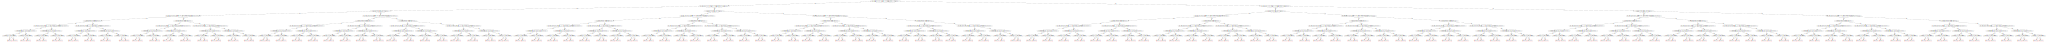

In [57]:
cbc_1.plot_tree(
    tree_idx=1,
    pool=pool
)


In [58]:
feature_importance = cbc_1.get_feature_importance(data=pool,
                                                  prettified=True,
                                                  verbose=True, type="PredictionValuesChange")
feature_importance


Used dataset leave statistics for fstr calculation


,Feature Id,Importances
0,Customer_CLV,46.689970
1,Customer_CreditScore,19.425240
2,Customer_DebtToIncomeRatio,17.442447
3,Customer_RelationshipLengthDays,12.074177
4,IH_Web_Inbound_Impression_pxLastOutcomeTime_Da...,2.233149
5,Customer_NumInvestmentAccount,1.123494
6,IH_Web_Inbound_Impression_pyHistoricalOutcomeC...,0.551755
7,Customer_NumDepositAccount,0.386668
8,IH_Retail_Inbound_Impression_pyHistoricalOutco...,0.073100
9,Customer_IsBankruptcy,0.000000


In [59]:
feature_importance = cbc_1.get_feature_importance(data=pool,
                                                  prettified=True,
                                                  verbose=True, type="LossFunctionChange")
feature_importance


Used Logloss metric for fstr calculation
Selected 2258 documents from 2258 for LossFunctionChange calculation.
Used Logloss metric for fstr calculation
Started LossFunctionChange calculation
2258/2258 Process documents	passed time: 43.2ms	remaining time: 0us


,Feature Id,Importances
0,Customer_CLV,1.491179e-01
1,Customer_CreditScore,5.544967e-02
2,Customer_DebtToIncomeRatio,5.303095e-02
3,Customer_RelationshipLengthDays,2.378310e-02
4,IH_Web_Inbound_Impression_pxLastOutcomeTime_Da...,9.037018e-03
5,IH_Web_Inbound_Impression_pyHistoricalOutcomeC...,1.160972e-03
6,IH_Web_Inbound_Clicked_pyHistoricalOutcomeCount,3.061825e-08
7,Customer_IsBankruptcy,0.000000e+00
8,Customer_OrganizationID,0.000000e+00
9,Customer_IsCustomerActive,0.000000e+00


In [60]:
# make the prediction using the resulting model
preds = cbc_1.predict(pool)
preds_proba = cbc_1.predict_proba(pool)
print(preds)
print(y_test)
print(preds_proba[:5])

print(cbc_1.score(pool))

print(cbc_1.predict(pool, 'RawFormulaVal')[:5])


['Clicked' 'NoResponse' 'NoResponse' ... 'Clicked' 'NoResponse'
 'NoResponse']
4595     NoResponse
14454    NoResponse
16068       Clicked
4004     NoResponse
18740       Clicked
6884     NoResponse
4636        Clicked
12594       Clicked
20229    NoResponse
9662        Clicked
9873     NoResponse
21904    NoResponse
3395     NoResponse
10302       Clicked
15353    NoResponse
8536        Clicked
7311        Clicked
8557     NoResponse
13645       Clicked
22299       Clicked
21480    NoResponse
7269     NoResponse
19647       Clicked
12217    NoResponse
4207        Clicked
6460        Clicked
20207       Clicked
3921        Clicked
14300    NoResponse
14942       Clicked
17430       Clicked
11360       Clicked
1304        Clicked
16695       Clicked
9187     NoResponse
2613        Clicked
11800    NoResponse
20734       Clicked
9344        Clicked
12508       Clicked
14848       Clicked
7738        Clicked
10278       Clicked
570         Clicked
6377        Clicked
20529    NoResponse
1

In [61]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, preds, labels=params.get('class_names')))
print(metrics.classification_report(
    y_test, preds, labels=params.get('class_names')))


[[ 761  141]
 [ 298 1058]]
              precision    recall  f1-score   support

  NoResponse       0.72      0.84      0.78       902
     Clicked       0.88      0.78      0.83      1356

    accuracy                           0.81      2258
   macro avg       0.80      0.81      0.80      2258
weighted avg       0.82      0.81      0.81      2258



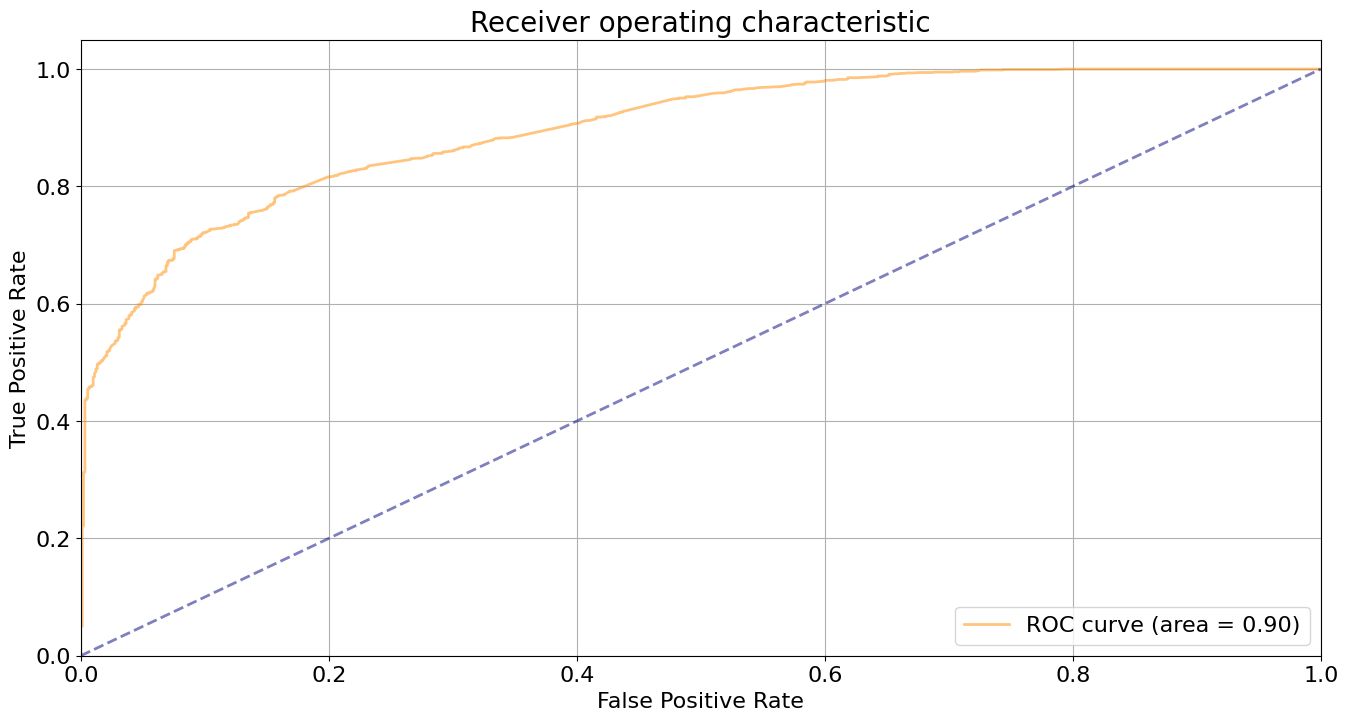

In [62]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

curve = get_roc_curve(cbc_1, pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [63]:
print('error:', 1-np.mean(preds == np.ravel(y_test)))


error: 0.19441984056687334


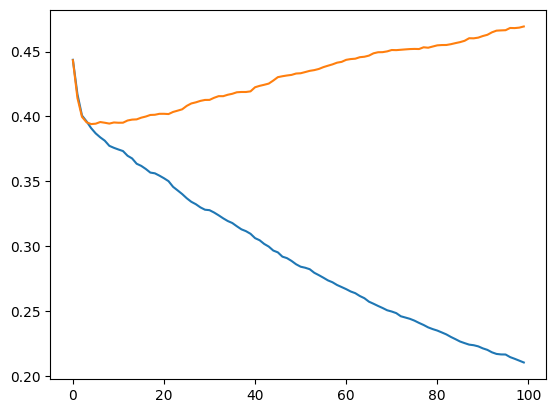

In [64]:
rmse_learn = pd.read_csv(
    'catboost_info/learn_error.tsv', header=0, delimiter='\t')
rmse_test = pd.read_csv('catboost_info/test_error.tsv',
                        header=0, delimiter='\t')
plt.plot(rmse_learn['Logloss'], label="Learn Error")
plt.plot(rmse_test['Logloss'], label="Test Error")


In [65]:
shap_values = cbc_1.get_feature_importance(pool, type="ShapValues")

In [66]:
expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]


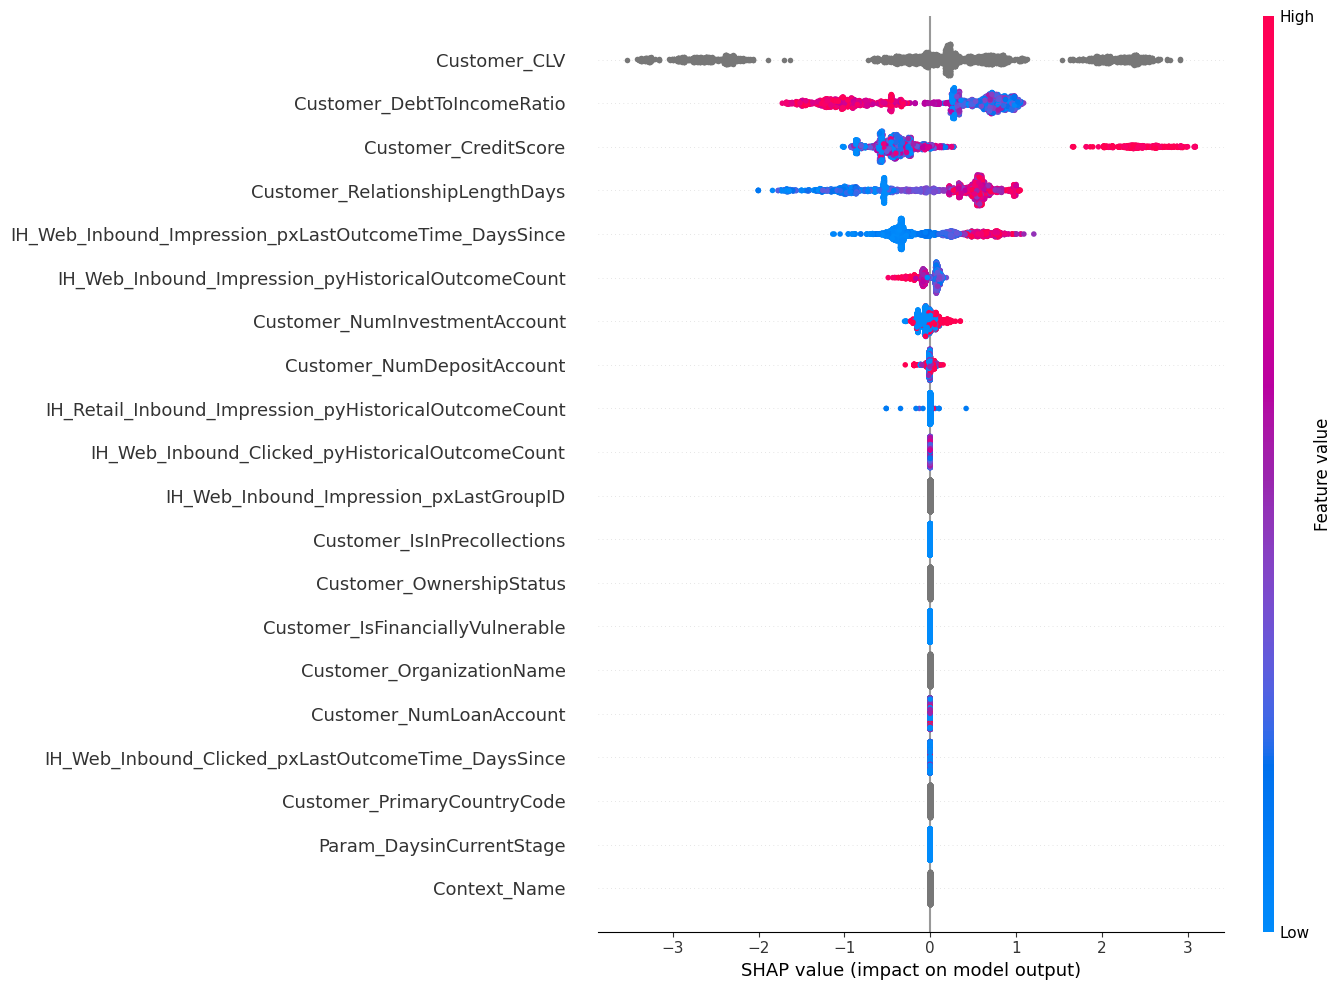

In [67]:
#%matplotlib widget
import shap

shap.initjs()
shap.summary_plot(shap_values, X_test, max_display=20, plot_size=[14,10])


In [68]:

shap.plots.force(expected_value, shap_values[50], feature_names=X_test.columns)


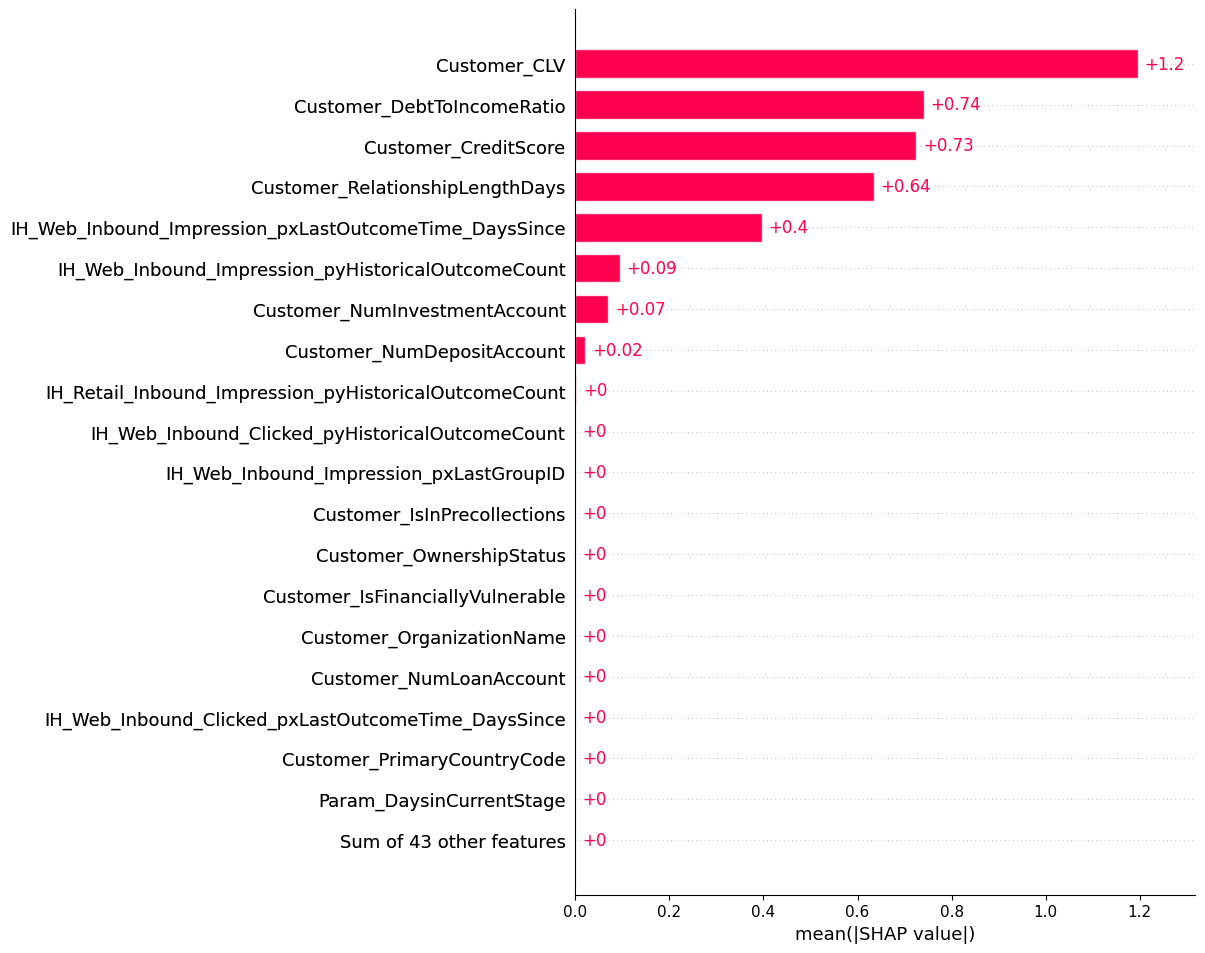

In [69]:
explainer = shap.Explainer(cbc_1)
shap_values_exp = explainer(X_test)
shap.plots.bar(shap_values_exp, max_display=20)

In [70]:
shap.initjs() 
shap.plots.force(expected_value, shap_values[99], features=X_test.iloc[-1:], feature_names=X_test.columns)

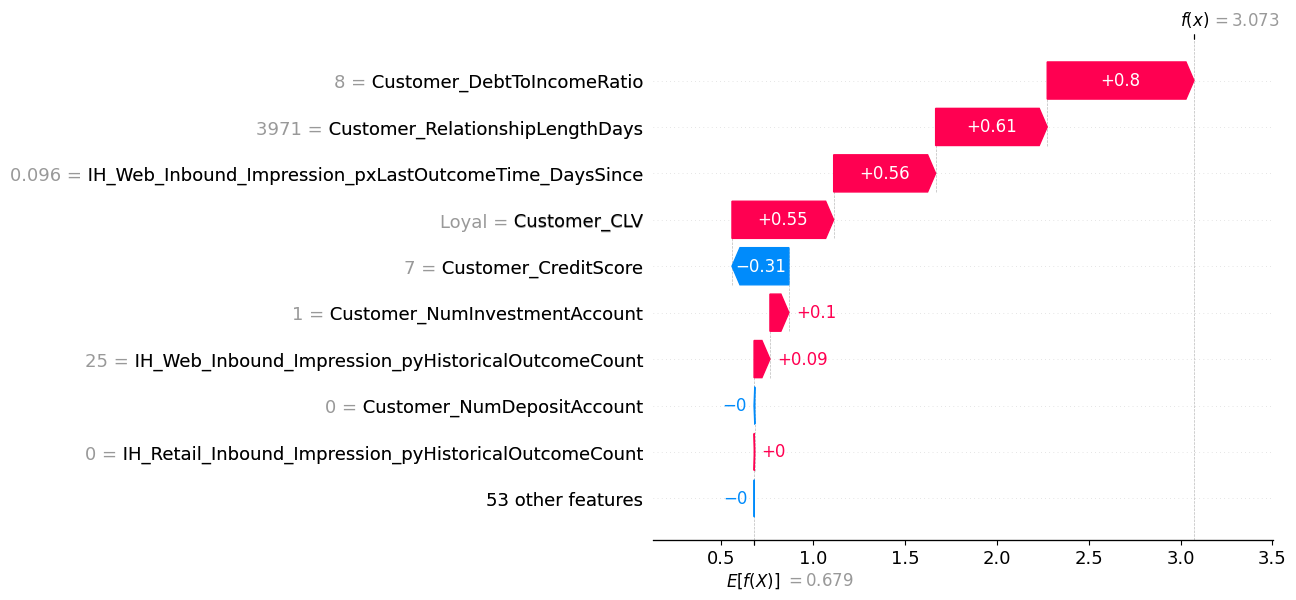

In [71]:
shap.plots.waterfall(shap_values_exp[7])